In [1]:
import hyperspy.api as hs
#import pyxem as ps
#import pixstem.api as pxs
#from pyxem.signals import diffraction2d as d2d#.Diffraction2D import get_radial_profile as ra
#or pyxem.utils.expt_utils.radial_average()
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import center_of_mass as CoM
from skimage import measure, feature, color, draw
from skimage import transform as tf
import sys
import dask.array as da
sys.path.append('/dls/science/groups/e02/Chris/Code/GitHub/Merlin-Medipix/epsic_tools/toolbox')
#r'Z:\Chris\Code\GitHub\Merlin-Medipix\epsic_tools\toolbox')
import warp_3d as wp
import radial_profile as ra
import pyFAI

In [2]:
#load data 
# data sets MG23962-1, 
#20191115 152525
#20191115 153027
#20191115 154136
#20191115 164919
#20191115 173432
#20191115 173849
#20191115 174126
#20191115 180203
#MG23962-2, 23962-3
pn ='/dls/e02/data/2020/cm26481-1/processing/Merlin/mg23962-1/processing/Merlin/20191115 152525' #also -2
fn = r'/PdLi_scan_array_253by255_diff_plane_515by515_.hdf5'#full dat set
fn_bin = r'/binned_diff_PdLi_scan_array_253by255_diff_plane_128by128_.hdf5' # data with diffraction axes binned by 4
#get full data set lazily
d = hs.load(pn+fn, lazy = True)
#load binned data set into memory
d_bin = hs.load(pn + fn_bin, lazy = True)


[########################################] | 100% Completed | 48.2s


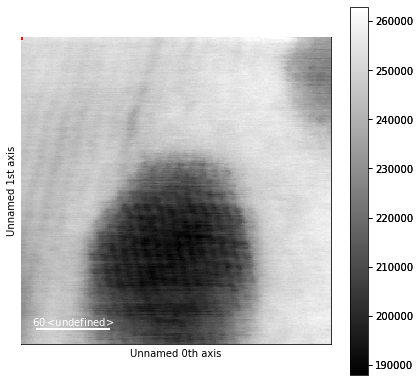

In [3]:
#get IBF image from binned datat
IBF = d_bin.sum(axis = (2,3))
IBF.compute()
IBF.plot()

[########################################] | 100% Completed | 46.6s


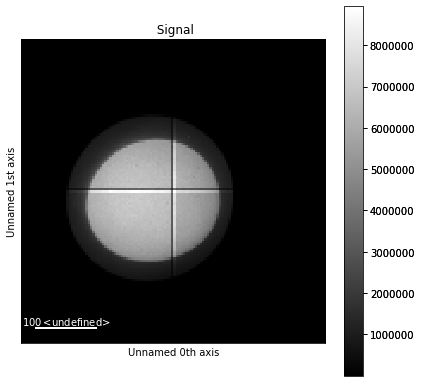

In [4]:
#get PACBED image from binned data
bin_PACBED = d_bin.sum(axis=(0,1))
bin_PACBED.compute()
bin_PACBED.plot()

(67.05063660192022, 53.54959381585431)


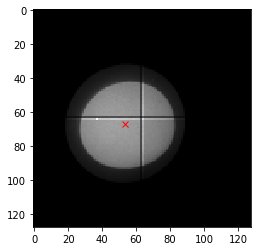

In [5]:
#calculate center of mass
bin_COM = CoM(bin_PACBED.data)
print(bin_COM)
plt.imshow(bin_PACBED.data)
plt.plot(bin_COM[1], bin_COM[0], 'rx')

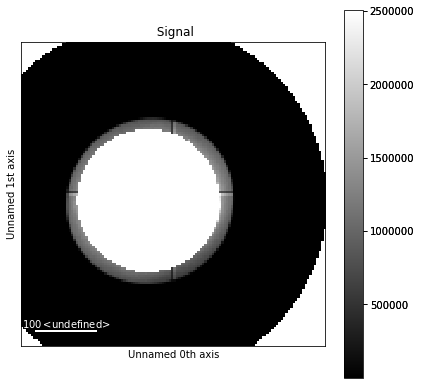

In [6]:
#create virtual anular detector
inner_px = 120
outer_px = 300
c_roi = hs.roi.CircleROI(bin_COM[1]*4, bin_COM[0]*4, outer_px, inner_px)
c = c_roi(bin_PACBED)
c.plot()

[########################################] | 100% Completed |  1min  6.2s


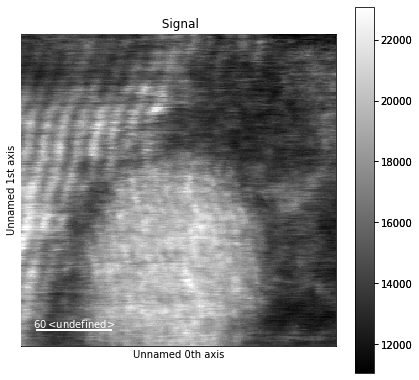

In [7]:
#plot ADF of binned data
ADF = c_roi(d_bin.T)
ADF = ADF.nansum(axis = (0,1))
ADF.compute()
ADF.plot()

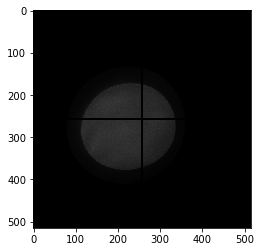

In [32]:
#get PACBED for unbinned diffraction patterns for small region of image
d_sub = d.inav[:20,:20].data
PACBED = d_sub.sum(axis = (0,1))
#store in memory
PACBED = PACBED.compute()
#remove dead px
#PACBED[PACBED  == 0 ] = PACBED.mean()
#PACBED = PACBED ** 0.05 # to aid visualisaton
plt.imshow(PACBED)

(272.8580606540621, 219.18720724619897)


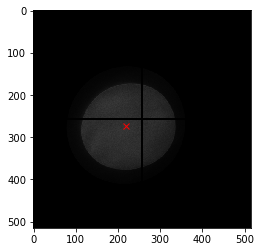

In [33]:
#calculate center of mass
COM = CoM(PACBED)
print(COM)
plt.imshow(PACBED.data)
plt.plot(COM[1], COM[0], 'rx')

297
294
303
295


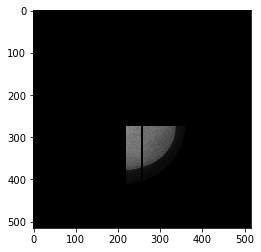

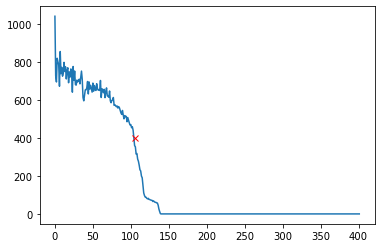

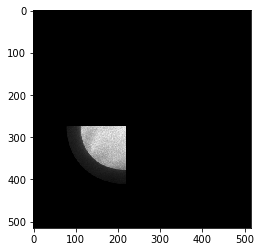

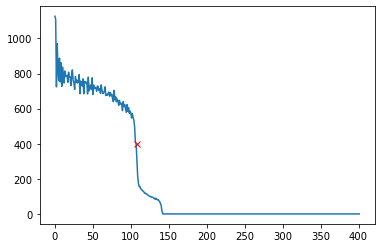

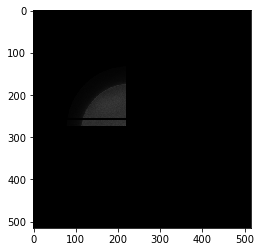

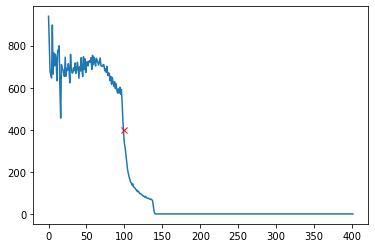

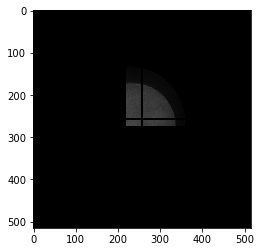

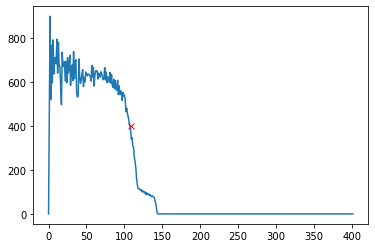

In [53]:
shape_PACBED = PACBED.data.shape
n_regs = 4
thresh = 400
edge_list = []
deg_step = 360 / n_regs
start_deg = 0
for i in np.arange(n_regs):
    end_deg = start_deg + deg_step
    rad_mask =ra.sector_mask(shape_PACBED, COM, 400, [start_deg, end_deg])
    PACBED_reg = rad_mask * PACBED
    plt.figure()
    plt.imshow(PACBED_reg)
    rad_REG = ra.radial_profile(PACBED_reg, COM)
    plt.figure()
    plt.plot(rad_REG)
    this_edge = np.where(rad_REG < thresh)
    #print(len(this_edge[0]))
    #print(len(thresh))
    use_edge = this_edge[0][0]
    n = 1
    while use_edge < 20:
        use_edge = this_edge[0][n]
        n = n + 1
    plt.plot(use_edge,thresh, 'rx')
    start_deg = end_deg
    #now convert back to cartesian
    edge_list.append(use_edge)

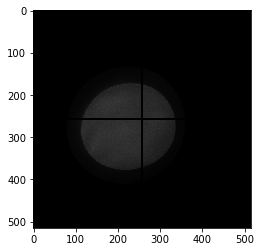

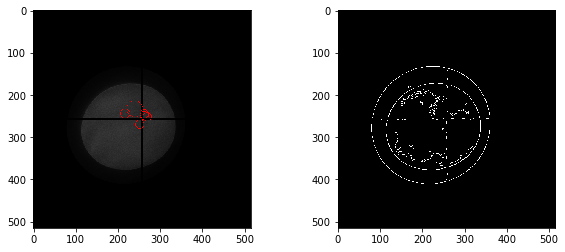

In [29]:
import numpy  as np
import matplotlib.pyplot as plt

import hyperspy.api as hs
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte



plt.figure()
plt.imshow(PACBED)
#%%
image = PACBED
image = (image / image.max())
edges = canny(image, sigma =1.5, low_threshold=0.001, high_threshold=0.03)


hough_radii = np.arange(10, 20,1)
hough_res = hough_circle(edges, hough_radii)

accums, cx, cy, radii  = hough_circle_peaks( hough_res, hough_radii, total_num_peaks = 7)

fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10,4))
image= color.gray2rgb(image)

for center_y, center_x, radius in zip(cy,cx,radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape = image.shape)
    image[circy,circx] = (220,0,0)


ax1.imshow(image, cmap = plt.cm.gray)
ax2.imshow(edges)
plt.show()
#%%
oval_points =[cx[1:], cy[1:]]

In [27]:
PACBED.data

In [5]:
#pass PACBED to  pixstem
s = ps.PixelatedSTEM(PACBED)
#get COM
s_com = s.center_of_mass(threshold = 1, show_progressbar = True)
print(s_com.data)

[########################################] | 100% Completed |  0.1s
[130.87650565 128.00593457]


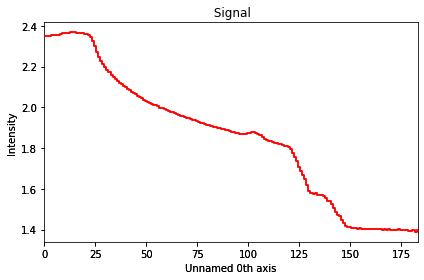

In [6]:
#Plot radial integration
s_radial = s.radial_integration(centre_x=s_com.data[0], centre_y=s_com.data[1])
s_radial.plot()
#plt.ylim([1.8, 1e6])

103.59696217560173


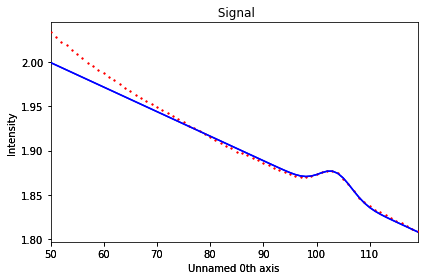

In [7]:
#fit to HOLZ ring
#get position from radial integration 
m_r = s_radial.create_model()
#add gaussian function and power law background
from hyperspy.components1d import PowerLaw
from hyperspy.components1d import Gaussian
from hyperspy.components1d import Polynomial
power = PowerLaw()
poly = Polynomial(order = 1)
g = Gaussian(A= 0.1, centre = 102, sigma = 4 )
#g2 = Gaussian(A= 10, centre = 100, sigma = 4 )
m_r.append(poly) # polynomial rather than power law as earlier raised PACBED to power **0.05
m_r.append(g)
#m_r.append(g2)
g.centre.bmin, g.centre.bmax = 90, 115
#g2.centre.bmin, g2.centre.bmax = 90, 110
m_r.set_signal_range(70.,120.)
m_r.multifit(fitter = 'mpfit', bounded = True, show_progressbar = True)
m_r.reset_signal_range()
m_r.isig[50:120].plot()
#plt.ylim([0,50])
print(g.centre.value)

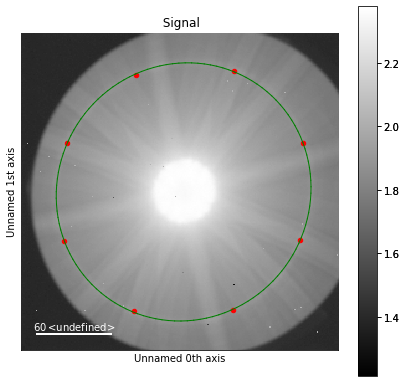

In [8]:
#fit ellipse to HOLZ ring 
#set centre position
s.axes_manager[0].offset, s.axes_manager[1].offset = - s_com.data[0], -s_com.data[1]
#fit
output2 = ra.fit_single_ellipse_to_signal(s, ([90,120]), angleN= 8, show_progressbar=False)
#and plot
output2[0].plot()#(vmin = 0, vmax = 1.5e6)

original params :  (<PixelatedSTEM, title: , dimensions: (|256, 256)>, -0.25629160507172594, 0.17665340310422903, 105.30901245257313, 101.72748290346485, 2.1587932422676626, 0.999503506088719)
final params :  (<PixelatedSTEM, title: , dimensions: (|256, 256)>, -0.16356097857181745, 0.20618543124126001, 105.4617149763437, 105.14581049861627, 2.0509429569819053, 0.9999969894267582)


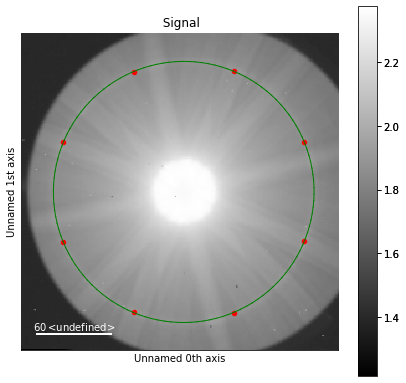

In [9]:
#get warp matrix
#build params ([centerx, centery], angle, axes)
params =  [(s_com.data[0]+output2[1],s_com.data[1] + output2[2]), output2[5], (output2[3], output2[4])]
print('original params : ', output2)
#compute transform
transform = wp.compute_transform(output2[0].data, params)
#transform data
dst = tf.warp(output2[0].data, transform,preserve_range = True, order=1)
#pass back to pixstem
wp_dat = ps.PixelatedSTEM(dst)
#set bfd center (using from unwarped data)
wp_dat.axes_manager[0].offset, wp_dat.axes_manager[1].offset = - s_com.data[0], -s_com.data[1]
#fit
output3 = ra.fit_single_ellipse_to_signal(wp_dat, ([90,120]), angleN= 8, show_progressbar=False)
#and plot
print('final params : ', output3)
output3[0].plot()#(vmin = 0, vmax = 1.5e6)


In [10]:
#transform full data sets

d_4d_shape = d.data.shape
d_4d = d.data
#get transform coords
coords =  tf.warp_coords(transform, (d_4d_shape[-2], d_4d_shape[-1]))

#lazy data warp
warped_data= d_4d.map_blocks(wp.warp_all_np, dtype = 'uint8', coords = coords, order = 5)


In [12]:
#save to hdf5 file
import time
wf = fn[:-5] + '_warp5.hdf5'
pnwf = pn + wf
print(pnwf)
t0 = time.time()
warped_data.to_hdf5(pnwf, 'data', compression = 'gzip')
print('processed on local cpu in  : ', time.time() - t0 , ' s') # nb most of this is likely transfering to and from network drive

Y:\2017\em16952-1\processing\Merlin\raw\011_big_film_512x512_warp5.hdf5
processed on local cpu in  :  42992.53516793251  s


In [17]:
#check data
import h5py
#wf = fn[:-5] + '_warp5.hdf5'
#pnwf = pn + wf
h5d = h5py.File(pnwf, 'r')
h5d_dat =h5d['data']
dask_data = da.from_array(h5d_dat)


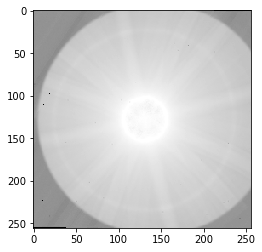

In [31]:
#get warped PACBED
w_sub = dask_data[:,400:]
w_PACBED = w_sub.sum(axis = (0,1))
#store in memory
w_PACBED = w_PACBED.compute()
#remove dead px
w_PACBED[PACBED  == 0 ] = w_PACBED.mean()
w_PACBED = w_PACBED ** 0.05 # to aid visualisaton
plt.imshow(w_PACBED)

[########################################] | 100% Completed | 22min 52.7s


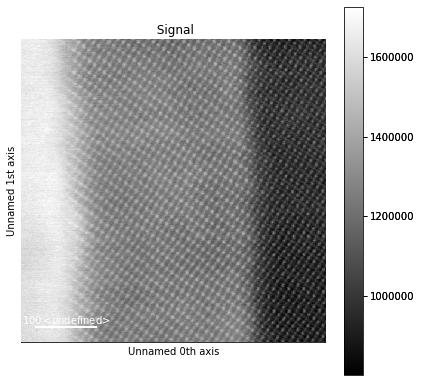

In [27]:
#reconstruct HAADF from warped data
warp_all = ps.PixelatedSTEM(dask_data, laxy = True)
warp_HAADF = warp_all.virtual_annular_dark_field(s_com.data[0], s_com.data[1], 10,100 )
warp_HAADF.plot()

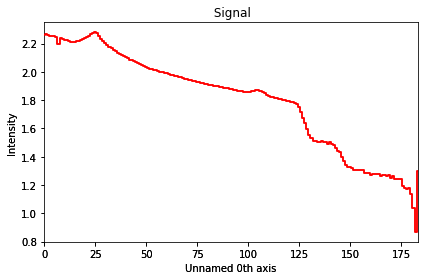

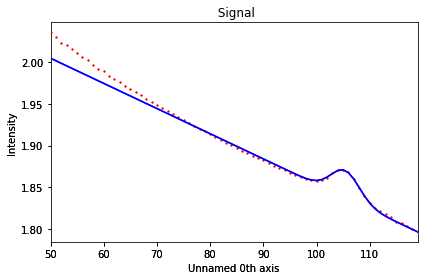

In [32]:
#passs to pixstem
ts = ps.PixelatedSTEM(w_PACBED)
#fit to HOLZ ring
#get position from radial integration 
ts_radial = ts.radial_integration(centre_x=s_com.data[0], centre_y=s_com.data[1])
ts_radial.plot()
m_t = ts_radial.create_model()
#powert = PowerLaw()
polyt = Polynomial(order = 1)
gt = Gaussian(A= 0.1, centre = 102, sigma = 4 )
#g2 = Gaussian(A= 10, centre = 100, sigma = 4 )
m_t.append(polyt)
m_t.append(gt)
#m_r.append(g2)
gt.centre.bmin, gt.centre.bmax = 90, 115
#g2.centre.bmin, g2.centre.bmax = 90, 110
m_t.set_signal_range(70.,120.)
m_t.multifit(fitter = 'mpfit', bounded = True, show_progressbar = True)
m_t.reset_signal_range()
m_t.isig[50:120].plot()

(-0.12058893883743743, 0.2339272792265, 105.51651084276435, 105.17807256488008, 2.0082759851936176, 0.9999969725971666)


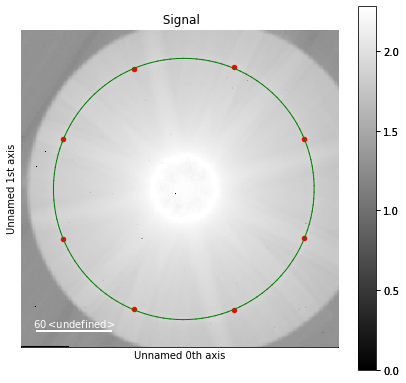

In [35]:
#fit ellipse 
ts.axes_manager[0].offset, ts.axes_manager[1].offset = - s_com.data[0], -s_com.data[1]
output4 = ra.fit_single_ellipse_to_signal(ts, ([90,120]), angleN= 8, show_progressbar=False)
print(output4[1:])
output4[0].plot()